# Applied Data Analysis - Fall 2016
## Twitter-Swisscom Project

### Event Detection

This notebook contains all the operation we made on the data to detect events in Switzerland as precisely as possible.
Here is a summary of what we did :

1 - [Load the data](#load_data)

2 - [Detection for one day columns](#one_day_detection)

&nbsp;&nbsp; 2.1 - [Use of DBSCAN for clustering](#DBSCAN)

3 - [Run detection on the whole data](#whole_data)

4 - [Scope of the events detected](#event_scope)

5 - [Event's country detection](#country_detection)

6 - [Trending events detection](#trending)

7 - [Save the events into csv for visualization](#save_events)

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from sklearn.cluster import DBSCAN
from sklearn import metrics

## Assumptions

Now that our dataframe is clean we want to find the event hidden in all those tweets. Here are our assumptions to find an event :

- An event takes place at a certain place described by longitude/latitude. (we take a radius of 3km)
- An event is described by hashtags it contains but this hashtags needs to be in at least 1/10 of tweets  a cluster contains.
- An event occurs during a certain  time. (we decide to find them day by day)

Avoid spam events :
- An event has a minimum number of people talking about it (we take 20) and a minimum of tweets. (we take 50)

### 1 - <a id='load_data'>Load the data</a> 
We load the csv file containing our tweets preprocessed.

In [56]:
tweets = pd.read_csv("../twitter-swisscom/event/tweets_processed.csv", sep=',', encoding='utf-8')

### 2 - <a id='one_day_detection'>Detection for one day<a>

Before applying the detection on the whole data, we want to do the detection on a specific day so that the pipeline is easy to understand.

We need to know how many days we have in our data.

In [57]:
days = np.unique(tweets['day'].values)
ndays = len(days)
print(ndays)

201


We take one of the day to show the detection on one day

In [58]:
from random import randint
index = randint(0,ndays)

day = tweets[tweets['day']==days[index]]
print(days[index])

2012-07-10 00:00:00


#### 2.1 - <a id='DBSCAN'>Use of DBSCAN for clustering<a>

We use [DBSCAN](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) to detect clusters of tweets that are close to each others. And we use this cluster assignment to detect events. Here are the parameters value we use to obtain our final result with explanation.

In [59]:
EPS = 3/6371 #radius of clusters (3km)
MIN = 5 #The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
ALGORITHM = 'ball_tree' #The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors
METRIC = 'haversine' #The metric to use when calculating distance between instances, haversine is for longitude/latitude in radians

We run the DBSCAN algorithm

In [60]:
X = np.radians(day.as_matrix(columns=['latitude', 'longitude']))
db = DBSCAN(eps=EPS, min_samples=MIN, algorithm=ALGORITHM, metric=METRIC).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
day = day.assign(cluster=db.labels_)

Number of clusters created on this day.

In [61]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 179


And we plot the clusters detected in function of the longitude/latitude of them.

C:\Users\Alain\Anaconda3\lib\site-packages\matplotlib\lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


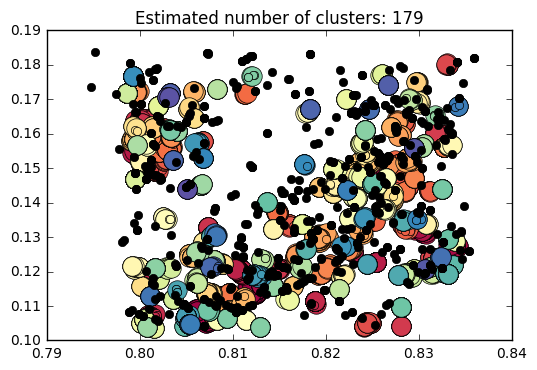

In [62]:
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### 3 - <a id='whole_data'>Run detection on the whole data<a>

We go through the clusters and find out if the corresponding tweets are linked by an event or not. To do so we first of all create a dataframe that will contain the events. (Name, date, keywords, hashtags, longitude, latitude, #of tweets, #of people, tweetids)

In [63]:
df_event = pd.DataFrame(columns=['name', 'date', 'keywords', 'hashtags', 'longitude', 'latitude', '# of tweets', '# of people', 'tweetids'])

Now we want to populate our dataframe with real event. So we go through all the clusters and find out the hashtags, keywords and corresponding event based on these two infos. We use the same pipeline we used above to detect the clusters.

To detect hashtags and keywords we use the assumptions we did at the start. 

In [64]:
iter_=0
print('Number of days to go through : ', ndays)
for day in days:
    if(iter_%100==0):
        print(str(iter_) + '/' + str(ndays))
    iter_+=1
    day_df = tweets[tweets['day']==day]
    
    X = np.radians(day_df.as_matrix(columns=['latitude', 'longitude']))
    db = DBSCAN(eps=EPS, min_samples=MIN, algorithm=ALGORITHM, metric=METRIC).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    day_df = day_df.assign(cluster=db.labels_)

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    for cluster in range(0,n_clusters_-1):
        ntweets = len(day_df[day_df['cluster']==cluster])
        npeople = len(np.unique(day_df[day_df['cluster']==cluster].userId))
        # Here we test if the number of people and the number of tweets are high enough to be detected as events
        if(ntweets>=50 & npeople>=20): 
            ids = list(day_df[day_df['cluster']==cluster].id.values)
            d_hashtags = dictionnary_from_hashtags(day_df, cluster)
            d_keywords = dictionnary_from_keywords(day_df, cluster)

            d_hashtags_detection = useful_(d_hashtags, 1/10, ntweets)
            d_keywords_detection = useful_(d_keywords, 1/10, ntweets)

            if(any(d_hashtags_detection)):
                position = find_position(day_df, cluster, ntweets)
                i = len(df_event)
                name = ""
                for elem in d_hashtags_detection.keys(): 
                    name += elem + " "
                df_event.loc[i] = ([name[:-1], day, list(d_keywords_detection.keys()), list(d_hashtags_detection.keys()), position[0], position[1], ntweets, npeople, ids])

Number of days to go through :  201
0/201
100/201
200/201


We print the number of events we detected and the head of it.

In [65]:
len_event = len(df_event)
print("Number of event without filtering the spam neither the event not in the scope : ", len_event)
df_event.head()

Number of event without filtering the spam neither the event not in the scope :  1


,name,date,keywords,hashtags,longitude,latitude,# of tweets,# of people,tweetids
0,parking,2012-07-10 00:00:00,"[(out, availability:, free, parking]",[parking],8.941555,46.005059,198.0,33.0,"[222513298887806977, 222517927117729792, 22252..."


### 4 - <a id='event_scope'>Scope of the event detected</a>

Our dataset should be containing tweets between 2010 and 2016 but we still want to make sure we don't have outliers so we filter it.

In [66]:
df_event['date'] = pd.DatetimeIndex(df_event['date']).normalize()

In [67]:
df_event = df_event[(df_event.date >= "2010-01-01") & (df_event.date <= "2016-12-31")]

We save our dataframe to find the countries linked with each event.

In [68]:
df_event.to_csv("../twitter-swisscom/event/event_no_country.csv", sep=',', encoding='utf-8', index=False)

### 5 - <a id='country_detection'>Event's country detection</a>

Here is the pipeline we used to find the country given the longitude/latitude of an event :
- Install OSGeo4W : https://trac.osgeo.org/osgeo4w/wiki
- Open the OSGeo4W shell
- Go to the directory where our script is (/country-detection)
- install pandas : pip install pandas
- run the script : python find_country.py


(in our script we use these two tools : https://github.com/che0/countries)

We then reload the dataframe with the countries and remove the one that are not in Switzerland

In [69]:
df_event = pd.read_csv("../twitter-swisscom/event/event_country.csv", sep=',', encoding='utf-8')

We want to keep only events that are in Switzerland to show them on our viz.

In [70]:
len_total = len(df_event)
df_event = df_event[df_event.country == 'CH']
len_swiss = len(df_event)
print("Total number of events : ", len_total)
print("Number of events in Switzerland : ", len_swiss)
print("Loss percentage : ", (1-(len_swiss/len_total))*100, "%")

Total number of events :  1
Number of events in Switzerland :  1
Loss percentage :  0.0 %


In [71]:
df_event.head()

,name,date,keywords,hashtags,longitude,latitude,# of tweets,# of people,tweetids,country
0,parking,2012-07-10,"['(out', 'availability:', 'free', 'parking']",['parking'],8.941555,46.005059,198.0,33.0,"[222513298887806977, 222517927117729792, 22252...",CH


In [72]:
df_event.to_csv("../twitter-swisscom/event/event_final_events.csv", sep=',', encoding='utf-8', index=False)

### 6 - <a id='trending'>Trending events detection</a>

After vizualizing our data on several years, we see that some events seems to not be spatial but only like trending hashtags, we can detect them by finding events that take place at the same time but in many different places. We don't want to show them on the map as there position is not really representative.

In [79]:
df_event = pd.read_csv("../twitter-swisscom/event/event_final_events.csv", sep=',', encoding='utf-8')

We create a new column with the 'Trending' value equals to False.

In [80]:
df_event['trending'] = "False"

We detect same events that are on the same day at different locations

In [81]:
trending_event = df_event.groupby(['name','date'])

In [82]:
namelist = []
def getnames(group):
    name = group.name
    if len(group['longitude'])>1:
        namelist.append(name[0])

trending_event.apply(getnames)

""


And set their 'Trending' value to True

In [83]:
df_event['trending'] = df_event['name'].isin(namelist)

In [84]:
print('Number of trending events detected : ', len(df_event[df_event['trending']==True]))

Number of trending events detected :  0


### 7 - <a id='save_events'>Save the events into csv for visualization</a>
Our final event dataframe is saved and used in the viz.

In [85]:
df_event.to_csv("../twitter-swisscom/event/events_detected.csv", sep=',', encoding='utf-8', index=False)